In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, Flatten
from transformers import TFBertModel, BertTokenizer

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re,nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [17]:
train_ds = pd.read_csv('/content/train.csv',encoding='latin1');
validation_ds = pd.read_csv('/content/test.csv',encoding='latin1');
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [18]:
train_ds['text'].fillna('',inplace=True)
validation_ds['text'].fillna('',inplace=True)

<ipython-input-18-cb58bb3e5260>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_ds['text'].fillna('',inplace=True)
<ipython-input-18-cb58bb3e5260>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [19]:
stop_word=set(stopwords.words('english'))
st=PorterStemmer()

def clear_text(text):
    text=str(text).lower()
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    text=re.sub('[^\w\s]','',text)
    tokens=word_tokenize(text)
    tokens=[token for token in tokens if token not in stop_word]
    tokens=[st.stem(token) for token in tokens]
    return ' '.join(tokens)

train_ds['text'] = train_ds['text'].fillna('').apply(clear_text)
validation_ds['text'] = validation_ds['text'].fillna('').apply(clear_text)

In [20]:
def func(sentiment):
    if sentiment =='positive':
        return 0
    elif sentiment =='negative':
        return 1
    else:
        return 2
train_ds['sentiment'] = train_ds['sentiment'].apply(func)
validation_ds['sentiment'] = validation_ds['sentiment'].apply(func)

In [21]:
x_train = np.array(train_ds['text'].tolist())
y_train = np.array(train_ds['sentiment'].tolist())
x_test = np.array(validation_ds['text'].tolist())
y_test = np.array(validation_ds['sentiment'].tolist())

In [22]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [31]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)
model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [32]:
def tokenize_inputs(text_list, tokenizer, max_len):
    return tokenizer(
        text_list.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )
tokenized_train = tokenize_inputs(x_train, tokenizer, max_len=128)
tokenized_test = tokenize_inputs(x_test, tokenizer, max_len=128)
print(type(tokenized_train["input_ids"]))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [33]:
from tensorflow.keras.layers import Input, Dense, Layer
from transformers import TFBertModel

class BertLayer(Layer):
    def __init__(self, bert_model_name, max_len):
        super(BertLayer, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.max_len = max_len

    def call(self, inputs):
        # Unpack dictionary inputs
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")
token_type_ids = Input(shape=(128,), dtype=tf.int32, name="token_type_ids")

bert_output = BertLayer("bert-base-uncased", max_len=128)([input_ids, attention_mask, token_type_ids])

cls_token = bert_output[:, 0, :]

x = tf.keras.layers.Dropout(0.2)(cls_token)
output = Dense(3, activation="softmax")(x)

# Build Model
final_model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)

# Compile Model
final_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary
final_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_type_ids            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_2 (BertLayer)  │ (None, 128, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0],  │
│                           │                        │                │ token_type_ids[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 768)            │              0 │ bert_layer_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │          2,307 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print(input_ids.shape)
print(attention_mask.shape)
print(input_ids.dtype)
print(attention_mask.dtype)

(None, 128)
(None, 128)
int32
int32


In [34]:
train_data = {
    "input_ids": tokenized_train["input_ids"],
    "attention_mask": tokenized_train["attention_mask"],
    "token_type_ids": tf.zeros_like(tokenized_train["input_ids"])
}

val_data = {
    "input_ids": tokenized_test["input_ids"],
    "attention_mask": tokenized_test["attention_mask"],
    "token_type_ids": tf.zeros_like(tokenized_test["input_ids"])
}

In [35]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train.argmax(axis=-1)),
    y=y_train.argmax(axis=-1)
)
class_weights = dict(enumerate(class_weights))

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

final_model.fit(
    train_data,
    y_train,
    validation_data=(val_data, y_test),
    epochs=10,
    batch_size=16,
    callbacks = [es, lr],
    class_weight = class_weights
)

Epoch 1/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 325s 177ms/step - accuracy: 0.3399 - loss: 1.1660 - val_accuracy: 0.5094 - val_loss: 1.0721
Epoch 2/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 262s 147ms/step - accuracy: 0.3375 - loss: 1.1454 - val_accuracy: 0.5163 - val_loss: 1.0733
Epoch 3/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 261s 147ms/step - accuracy: 0.3412 - loss: 1.1431 - val_accuracy: 0.5022 - val_loss: 1.0715
Epoch 4/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 262s 147ms/step - accuracy: 0.3359 - loss: 1.1436 - val_accuracy: 0.5238 - val_loss: 1.0655
Epoch 5/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 262s 147ms/step - accuracy: 0.3404 - loss: 1.1332 - val_accuracy: 0.5331 - val_loss: 1.0642
Epoch 6/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 262s 147ms/step - accuracy: 0.3331 - loss: 1.1368 - val_accuracy: 0.5063 - val_loss: 1.0608
Epoch 7/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 262s 147ms/step - accuracy: 0.3343 - loss: 1.1307 - val_accuracy: 0.5043 - val_loss: 1.0750
Epoch 8/10
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 250s 146ms/step - ac

In [36]:
predictions = final_model.predict(val_data, batch_size=16)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

301/301 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step
              precision    recall  f1-score   support

           0       0.33      0.27      0.29      1103
           1       0.29      0.60      0.39      1001
           2       0.84      0.57      0.68      2711

    accuracy                           0.51      4815
   macro avg       0.49      0.48      0.45      4815
weighted avg       0.61      0.51      0.53      4815



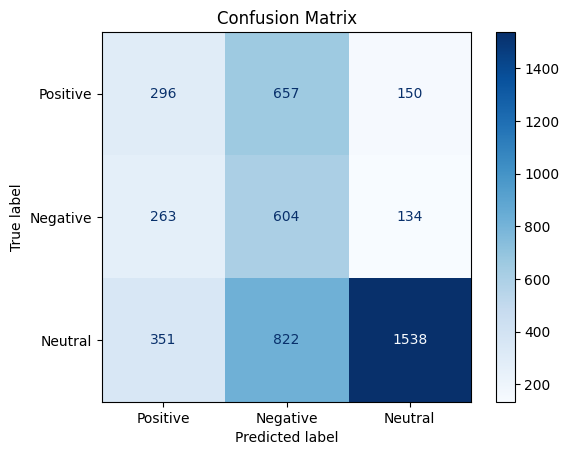

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative", "Neutral"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [38]:
def predict_user_input(user_input):
    user_input = clear_text(user_input)

    tokenized_input = tokenizer(
        user_input,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

    input_ids = tokenized_input["input_ids"]
    attention_mask = tokenized_input["attention_mask"]
    token_type_ids = tokenized_input["token_type_ids"]

    predictions = final_model.predict(
        {"input_ids": input_ids, "attention_mask": attention_mask, "token_type_ids": token_type_ids}
    )

    predicted_class = tf.argmax(predictions, axis=1).numpy()[0]

    sentiment_map = {0: "Positive", 1: "Negative", 2: "Neutral"}
    return sentiment_map[predicted_class]

In [44]:
user_input = input("Enter the string: ")
print(f"The predicted sentiment is: {predict_user_input(user_input)}")

Enter the string: this is one excellent product
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted sentiment is: Positive
